In [1]:
import datetime

import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import src.nzthermo as nzt

In [2]:
# load data
isobaric = xr.open_dataset(
    "data/hrrr.t00z.wrfprsf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "isobaricInhPa"}},
)
surface = xr.open_dataset(
    "data/hrrr.t00z.wrfsfcf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface", "stepType": "instant"}},
)
T = isobaric["t"].to_numpy()  # (K) (Z, Y, X)
Z, Y, X = T.shape
N = Y * X
T = T.reshape(Z, N).transpose()  # (N, Z)

P = isobaric["isobaricInhPa"].to_numpy().astype(np.float32) * 100.0  # (Pa)
Q = isobaric["q"].to_numpy()  # (kg/kg) (Z, Y, X)
Q = Q.reshape(Z, N).transpose()  # (N, Z)


latitude = isobaric["latitude"].to_numpy()
longitude = isobaric["longitude"].to_numpy()
longitude = (longitude + 180) % 360 - 180
timestamp = datetime.datetime.fromisoformat(isobaric["time"].to_numpy().astype(str).item())

extent = [longitude.min(), longitude.max(), latitude.min(), latitude.max()]

Ignoring index file 'data/hrrr.t00z.wrfprsf00.grib2.9093e.idx' incompatible with GRIB file
Ignoring index file 'data/hrrr.t00z.wrfsfcf00.grib2.9093e.idx' incompatible with GRIB file


In [3]:
import metpy.calc as mpcalc
from metpy.units import units

idx = np.argmax(surface["cape"].to_numpy().ravel())
t = T[idx:idx+1, :]
td = nzt.dewpoint_from_specific_humidity(P, Q[idx:idx+1, :])

%timeit nzt.cape_cin(P, t, td, nzt.parcel_profile(P, t[:, 0], td[:, 0]))

K = units.K
Pa = units.Pa

p = P * Pa
t = T[idx, :] * K
q = Q[idx, :]
td = mpcalc.dewpoint_from_specific_humidity(p, q)

%timeit mpcalc.cape_cin(p, t, td, mpcalc.parcel_profile(p, t[0], td[0]))

The slowest run took 7.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1.46 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.9 ms ± 99 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
Td = nzt.dewpoint_from_specific_humidity(P[np.newaxis], Q)
prof = nzt.parcel_profile(P, T[:, 0], Td[:, 0]) # (N, Z)

In [5]:
# compute CAPE and CIN
CAPE, CIN = nzt.cape_cin(P, T, Td, prof)

CAPE = CAPE.reshape(Y, X)
CIN = CIN.reshape(Y, X)

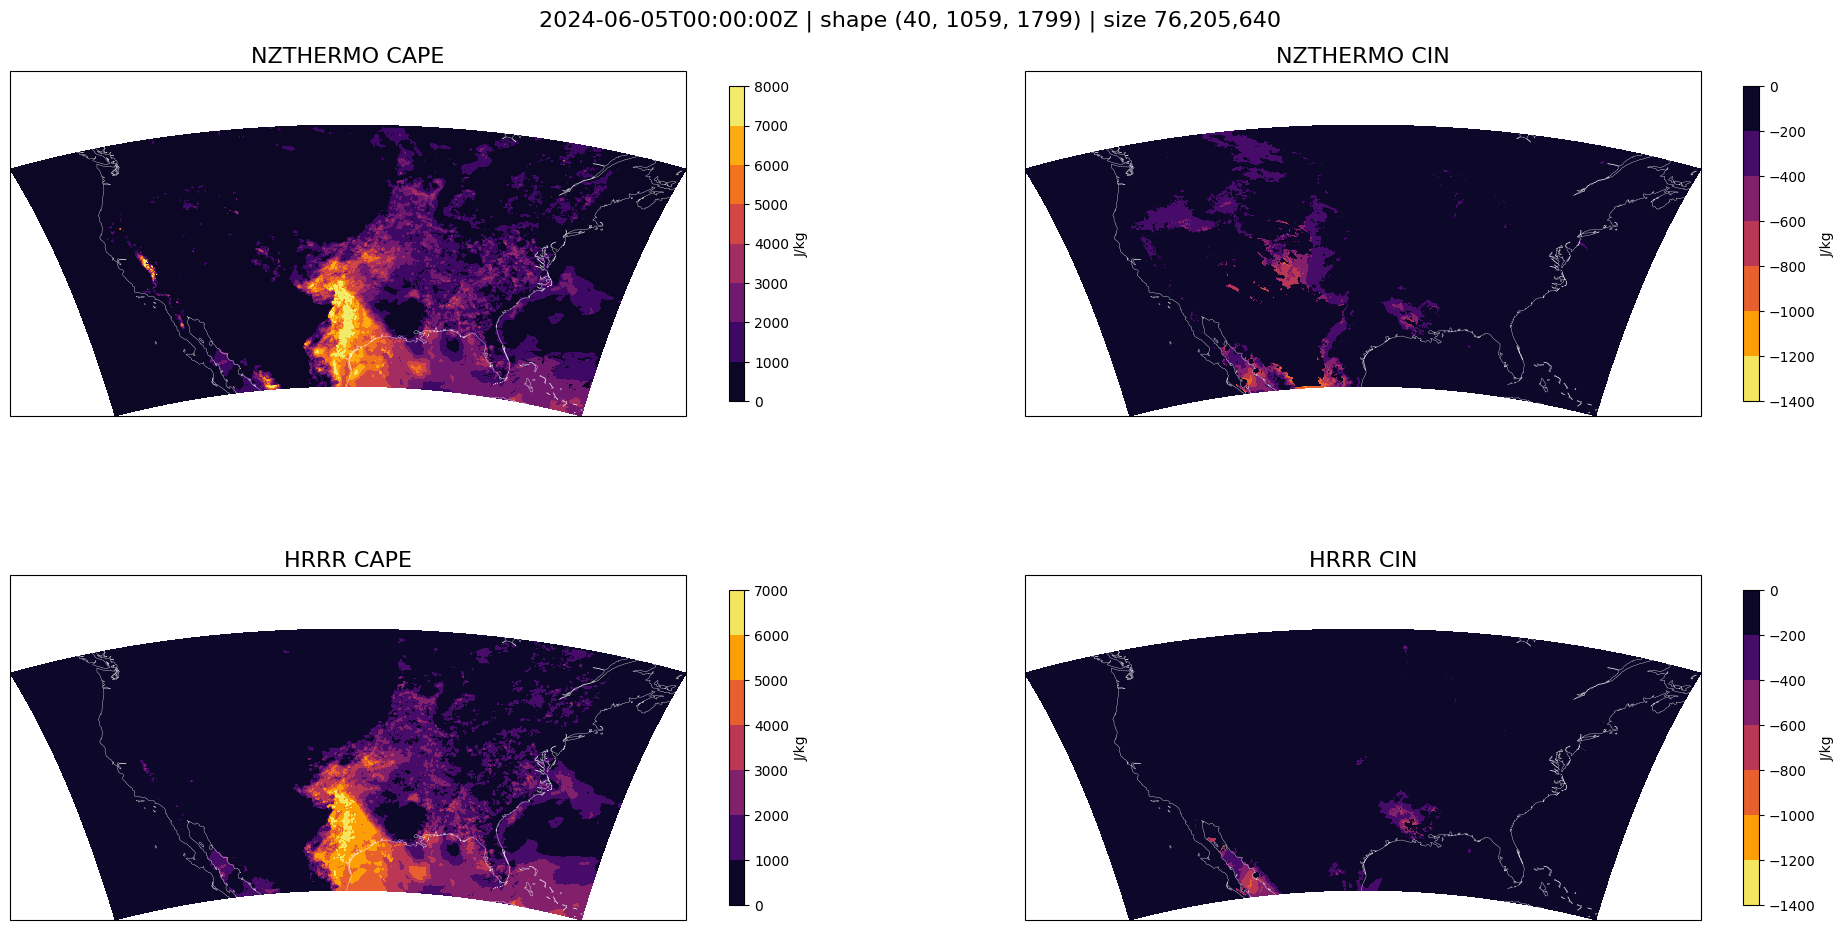

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12), subplot_kw={"projection": ccrs.PlateCarree()})
fig.suptitle(f"{timestamp:%Y-%m-%dT%H:%M:%SZ} | shape {Z, Y, X} | size {Z*Y*X:,}", fontsize=16, y=0.9)


# I suspect that the difference between our cape calculations and the MRMS cape calculations is due
# to the fact we are not actually starting at the surface or accounting for surface elevation.
# leading to inflated cape values in areas of higher elevation.
cape = np.where(CAPE < 8000, CAPE, 8000)
cin = np.where(CIN > -1400, CIN, -1400)

for ax, data, title, cmap in zip(
    axes[0], [cape, cin], ["NZTHERMO CAPE", "NZTHERMO CIN"], ["inferno", "inferno_r"]
):
    ax.coastlines(color="white", linewidth=0.25)
    ax.set_title(title, fontsize=16)
    ax.set_global()
    ax.set_extent(extent)
    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)

HRRR_CAPE = surface["cape"].to_numpy()
HRRR_CIN = surface["cin"].to_numpy()
for ax, data, title, cmap in zip(
    axes[1], [HRRR_CAPE, HRRR_CIN], ["HRRR CAPE", "HRRR CIN"], ["inferno", "inferno_r"]
):
    ax.coastlines(color="white", linewidth=0.25)
    ax.set_title(title, fontsize=16)
    ax.set_global()
    ax.set_extent(extent)
    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)



In [7]:
import numpy as np
from src.nzthermo._ufunc import not_nan
#benchmark np.isnan(x) vs x == x
# 
# 
x = np.random.rand(1000, 1000)
# set random values to nan
x[x < 0.5] = np.nan

# def not_nan(x):
#     return ~np.isnan(x)
%timeit np.isnan(x)
%timeit (~np.isnan(x))
%timeit x == x
%timeit not_nan(x)


ImportError: cannot import name 'not_nan' from 'src.nzthermo._ufunc' (/home/leaver/nzthermo/src/nzthermo/_ufunc.cpython-312-x86_64-linux-gnu.so)